In [2]:
import numpy as np
import pandas as pd
from scipy.stats import t
from scipy.stats import norm

from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split  
from sklearn.datasets import load_diabetes

import ipywidgets as widgets
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")
sns.set('notebook', font_scale=1.7)
%matplotlib inline

# Регуляризация

Для начала вспомним, что означают слова Ridge, Lasso и Elastic. Из курса статистики вы знаете, что такое линейная регрессия. 
* **Ridge** &mdash; это модель линейной регрессии, которая минимизирует $\lVert y - X \theta\rVert^2_2 + \alpha \cdot \lVert\theta\rVert^2_2$, где $y$ &mdash; истинные значения целевой переменной, $X$ &mdash; матрица "объект-признак", $\theta$ &mdash; параметры модели, $\alpha$ &mdash; параметр регуляризации.  
* **Lasso**-регрессия минимизирует $\lVert y - X \theta\rVert^2_2 + \alpha \cdot \lVert\theta\rVert_1$   
* **Elastic**-регрессия минимизирует $\lVert y - X\theta\rVert^2_2 + \alpha_1 \cdot \lVert\theta\rVert_1 + \alpha_2 \cdot \lVert\theta\rVert^2_2$. Таким образом Elastic-регрессия является компромиссом между $l_1$ и $l_2$ регуляризацией, позже мы в этом убедимся. 

Остановимся подробнее на каждой из моделей в контексте их использования с помощью библиотеки sklearn.

Рассмотрим работу линейных моделей на данных о диабете. Мы будем восстанавливать зависимость количественного показателя прогрессирования заболевания от давления, массы, пола, возраста и шести показателей сыворотки крови.

## Данные

Считываем данные:

In [3]:
X = load_diabetes()['data']
y = load_diabetes()['target']
columns_name = load_diabetes()['feature_names'] + ['target']

data = pd.DataFrame(np.hstack((X, y.reshape(-1, 1))), columns=columns_name)

Описание датасета:

In [4]:
print(load_diabetes()['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, T-Cells (a type of white blood cells)
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, thyroid stimulating hormone
      - s5      ltg, lamotrigine
      - s6      glu, blood sugar level

Note: Each of these 10 feature va

In [5]:
data.describe().round(4)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
count,442.0000,442.0000,442.0000,442.0000,442.0000,442.0000,442.0000,442.0000,442.0000,442.0000,442.0000
mean,-0.0000,0.0000,-0.0000,0.0000,-0.0000,0.0000,-0.0000,0.0000,-0.0000,-0.0000,152.1335
std,0.0476,0.0476,0.0476,0.0476,0.0476,0.0476,0.0476,0.0476,0.0476,0.0476,77.0930
min,-0.1072,-0.0446,-0.0903,-0.1124,-0.1268,-0.1156,-0.1023,-0.0764,-0.1261,-0.1378,25.0000
25%,-0.0373,-0.0446,-0.0342,-0.0367,-0.0342,-0.0304,-0.0351,-0.0395,-0.0332,-0.0332,87.0000
50%,0.0054,-0.0446,-0.0073,-0.0057,-0.0043,-0.0038,-0.0066,-0.0026,-0.0019,-0.0011,140.5000
75%,0.0381,0.0507,0.0312,0.0356,0.0284,0.0298,0.0293,0.0343,0.0324,0.0279,211.5000
max,0.1107,0.0507,0.1706,0.1320,0.1539,0.1988,0.1812,0.1852,0.1336,0.1356,346.0000


Как видим, данные уже центрированы.

## Ridge-регрессия

Используем Ridge-регрессию:

In [6]:
model = Ridge(
    # коэффициент регуляризации, чем больше - тем сильнее регуляризация
    alpha=1.0,
    # использовать ли параметр-остаток при обучении 
    fit_intercept=True,
    # мак симальное количество итераций в методе оптимизации
    # при использовании итеративного метода
    max_iter=100,
    # точность решения, 
    # чем значение меньше, тем больше может потребоваться итераций
    tol=0.0001,
    # используемый метод оптимизации
    solver='auto'
)

Рассмотрим подробнее параметр `solver`.

 Доступные параметры:

* `auto` выбирает автоматически под тип даннных.
  

* `svd` использует сингулярное разложение матрицы для вычисления коэффициентов регрессии. Более стабильный метод для вырожденных матриц, чем метод `cholesky`.
  

* [`cholesky`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.solve.html) использует функцию из `scipy.linalg.solve`. 
  

* [`sparse_cg`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.cg.html) использует функцию из `scipy.sparse.linalg.cg`.
  

* [`lsqr`](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.linalg.lsqr.html) использует функцию из `scipy.sparse.linalg.lsqr`.
  

* `sag` и `saga` - стохастический градиентный спуск. Метод `saga` заявлен как улучшенная версия метода `sag`. Данные методы являются итеративными и лучше сходятся, когда признаки находятся в одном масштабе (то есть для данных нужно выполнять некоторый препроцессинг, например, при помощи `StandartScaler` из `sklearn`).

Обучаем модель.

In [7]:
model.fit(X, y)

Ridge(max_iter=100, tol=0.0001)

Посмотрим на различные параметры модели.

Коэффициенты модели.

In [8]:
model.coef_

array([  29.46574564,  -83.15488546,  306.35162706,  201.62943384,
          5.90936896,  -29.51592665, -152.04046539,  117.31171538,
        262.94499533,  111.878718  ])

Свободный параметр.

In [9]:
model.intercept_

152.13348416289622

Число итераций, вернет None если solver не итеративный.

In [10]:
model.n_iter_ 

Настройки модели, которые использовались при обучении.

In [11]:
model.get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': 100,
 'normalize': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.0001}

Теперь займемся визуализацией. Посмотрим, как ведут себя предсказания в зависимости от изменения параметров модели.

In [12]:
def linear_predictor(alpha, model, count_of_objects=20):
    """Данная функция строит график предсказаний модели 
    на первых count_of_objects объектах датасета.
    
    :param alpha: коэффициент регуляризации
    :param model: тип модели
    """

    if model == 'Ridge':
        model = Ridge(alpha=alpha, max_iter=1000, fit_intercept=True)
    elif model == 'Lasso':
        model = Lasso(alpha=alpha, max_iter=1000, fit_intercept=True)
    elif model == 'Elastic':
        model = ElasticNet(alpha=alpha, max_iter=1000, fit_intercept=True)

    model.fit(X, y)
    y_pred = model.predict(X)

    plt.figure(figsize=(14, 5))

    plt.scatter(np.arange(count_of_objects), y_pred[:count_of_objects], 
              color='#0066FF', label='Предсказания модели')
    plt.plot(np.arange(count_of_objects), y_pred[:count_of_objects], 
          color='#0066FF')
    plt.scatter(np.arange(count_of_objects), y[:count_of_objects], 
                color='#FF3300', label='Истинные значения')

    plt.grid(ls=':')
    plt.xlabel('Номер объекта', fontsize=19)
    plt.xticks(np.arange(count_of_objects))
    plt.ylabel('Предсказание', fontsize=19)
    plt.title('Предсказания на {} объектах'.format(count_of_objects), 
              fontsize=22)
    plt.legend(fontsize=19)
    plt.show() 

In [14]:
# создать виджет, но не отображать его
ip = widgets.interactive(
    linear_predictor, 
    alpha=widgets.FloatSlider(min=0.0001, max=10, step=0.01, value=1),
    model='Ridge'
);

# отображаем слайдер
display(widgets.HBox(ip.children[:1]))

# отображаем вывод функции
display(ip.children[-1])
ip.update() # чтобы функция запустилась до первого изменения слайдеров

Output()

## Lasso-регрессия

In [15]:
model = Lasso(
    # коэффициент регуляризации, чем больше - тем сильнее регуляризация
    alpha=1.0,
    # использовать ли параметр-остаток при обучении
    fit_intercept=True,
    # максимальное количество итераций в методе оптимизации
    max_iter=100,
    # точность решения, 
    # чем значение меньше, тем больше может потребоваться итераций
    tol=0.0001,
    # использовать ли предпосчитанную матрицу Грамма для ускорения расчетов
    precompute=True,
    # использовать ли результаты последнего обучения для инициализации
    warm_start=False,
    # если True, то будет подбирать положительные коэффициенты
    positive=False  
)

Для оптимизации используется покоординатный градиентный спуск.

Обучаем модель

In [16]:
model.fit(X, y)

Lasso(max_iter=100, precompute=True)

Посмотрим на различные параметры модели.

Коэффициенты модели.

In [17]:
model.coef_

array([  0.        ,  -0.        , 367.70185207,   6.30190419,
         0.        ,   0.        ,  -0.        ,   0.        ,
       307.6057    ,   0.        ])

Свободный параметр.

In [18]:
model.intercept_

152.13348416289637

Разряженное представление коэффициентов, хранятся только ненулевые элементы.

In [19]:
model.sparse_coef_ 

<1x10 sparse matrix of type '<class 'numpy.float64'>'
	with 3 stored elements in Compressed Sparse Row format>

In [20]:
print(model.sparse_coef_)

  (0, 2)	367.7018520698162
  (0, 3)	6.301904186054627
  (0, 8)	307.60570000448166


Количество итераций.

In [21]:
model.n_iter_ 

8

Визуализация.

In [22]:
# создать виджет, но не отображать его
ip = widgets.interactive(
    linear_predictor, 
    alpha=widgets.FloatSlider(min=0.0001, max=10, step=0.01, value=1),
    model="Lasso"
);

# отображаем слайдер
display(widgets.HBox(ip.children[:1]))

# отображаем вывод функции
display(ip.children[-1])
ip.update() # чтобы функция запустилась до первого изменения слайдеров

Output()

# Elastic-регрессия

In [21]:
model = ElasticNet(
    # коэффициент регуляризации, чем больше - тем сильнее регуляризация
    alpha=0.01, 
    # какое предпочтение отдавать l1, а не l2
    l1_ratio=0.6, 
    # использовать ли параметр-остаток при обучении
    fit_intercept=True,    
    # максимальное количество итераций в методе оптимизации
    max_iter=100,
    # точность решения, 
    # чем значение меньше, тем больше может потребоваться итераций
    tol=0.0001, 
    # использовать ли предпосчитанную матрицу Грамма для ускорения расчетов
    precompute=True,  
    # использовать ли результаты последнего обучения для инициализации
    warm_start=False, 
    # если True, то будет подбирать положительные коэффициенты
    positive=False  
)

Для оптимизации используется покоординатный градиентный спуск.

Разберемся чуть подробнее в связи между `alpha`, `l1_ratio` с $\alpha_1, \alpha_2$, которые мы вводили:

$$
\verb|alpha| = \alpha_1 + 2\alpha_2
\\
\verb|l1_ratio| = \frac{\alpha_1}{\alpha_1 + 2\alpha_2}
\\
\alpha_1 = \verb|alpha| \cdot \verb|l1_ratio|
\\
\alpha_2 = \frac{1}{2} \verb|alpha| \cdot (1 - \verb|l1_ratio|)
$$

 Обучаем модель.

In [22]:
model.fit(X, y)

ElasticNet(alpha=0.01, copy_X=True, fit_intercept=True, l1_ratio=0.6,
           max_iter=100, normalize=False, positive=False, precompute=True,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

Посмотрим на различные параметры модели.

Коэффициенты модели.

In [23]:
model.coef_

array([  32.69601043,  -46.27021937,  237.0691138 ,  160.4502964 ,
         17.84040055,   -5.07757963, -126.15582569,  106.14137675,
        206.58033298,  102.02605962])

Свободный параметр.

In [24]:
model.intercept_

152.13348416289614

Разряженное представление коэффициентов, хранятся только ненулевые элементы.

In [25]:
model.sparse_coef_ 

<1x10 sparse matrix of type '<class 'numpy.float64'>'
	with 10 stored elements in Compressed Sparse Row format>

In [26]:
print(model.sparse_coef_)

  (0, 0)	32.69601043051562
  (0, 1)	-46.270219374896975
  (0, 2)	237.06911379940732
  (0, 3)	160.45029639906892
  (0, 4)	17.840400545463943
  (0, 5)	-5.077579634271987
  (0, 6)	-126.1558256932387
  (0, 7)	106.14137675009546
  (0, 8)	206.5803329845972
  (0, 9)	102.02605961677288


Количество итераций.

In [27]:
model.n_iter_ 

8

Визуализация.

In [28]:
# создать виджет, но не отображать его
ip = widgets.interactive(
    linear_predictor, 
    alpha=widgets.FloatSlider(min=0.0001, max=0.1, step=0.001, value=0.01),
    model="Elastic"
);

# отображаем слайдер
display(widgets.HBox(ip.children[:1]))

# отображаем вывод функции
display(ip.children[-1])
ip.update() # чтобы функция запустилась до первого изменения слайдеров

Output()

## Сравнение моделей

Рассмотрим графики зависимости значений параметров моделей от параметра регуляризации.

In [29]:
def draw_track(model, X, y, log_min, log_max, num, title='', figsize=(12, 6)):
    """Данная функция строит график зависимости значений 
    коэффициентов модели от параметра регуляризации.
    
    :param model: модель
    :param X: регрессоры
    :param y: отклик
    :param log_min: десятичный логарифм 
        минимального значения коэффициента регуляризации
    :param log_max: десятичный логарифм 
        максимального значения коэффициента регуляризации
    :param num: количество элементов в сетке для коэффициента регуляризации
    :param title: заголовок графика
    :param figsize: размер полотна
    """
    
    alphas = np.logspace(log_min, log_max, num)   
    coefs = []
    for a in alphas:
        if 'l1_ratio' in model.get_params():
            # равномерно распределим alpha по обоим коэффициентам
            a *= 3/2
            model.set_params(alpha=a)
        else:
            model.set_params(alpha=a)
        model.fit(X, y)
        coefs.append(model.coef_)

    plt.figure(figsize=figsize)
    ax = plt.gca()
    ax.hlines(0, 10 ** log_min, 10 ** log_max, linewidth=15, alpha=0.15)
    ind = 1
    for coef in np.array(coefs).T:
        label = r'$\theta_{' + str(ind) + '}$'
        ax.plot(alphas, coef, linewidth=2, label=label)
        ind += 1
        
    ax.set_xscale('log')
    ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
    plt.xlabel('alpha', fontsize=19)
    plt.ylabel('weights', fontsize=19)
    plt.title(title, fontsize=22)
    plt.legend(loc='upper left', fontsize=15)
    plt.axis('tight')
    plt.show()

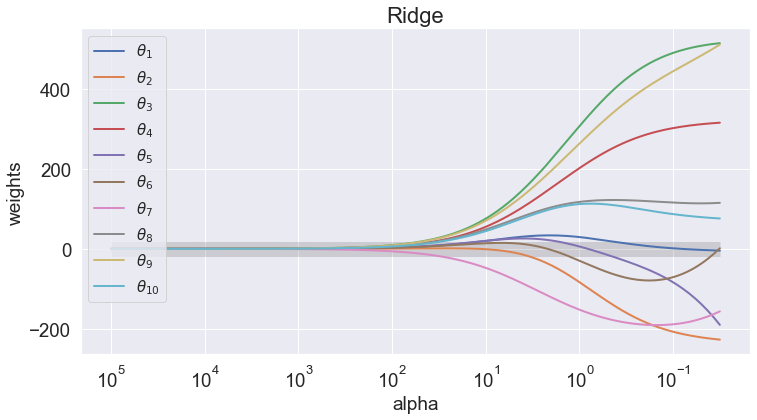

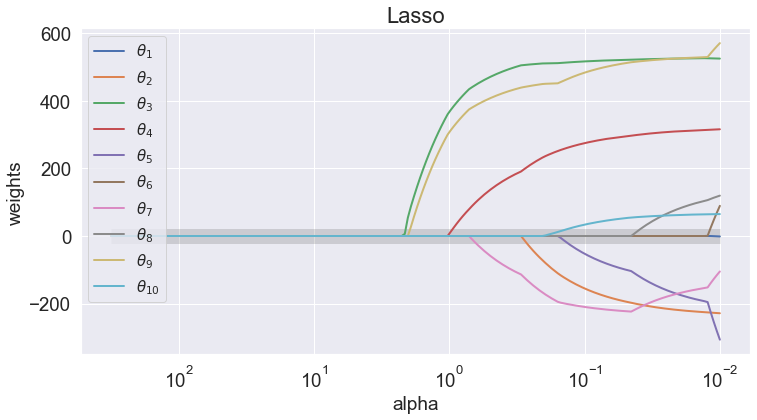

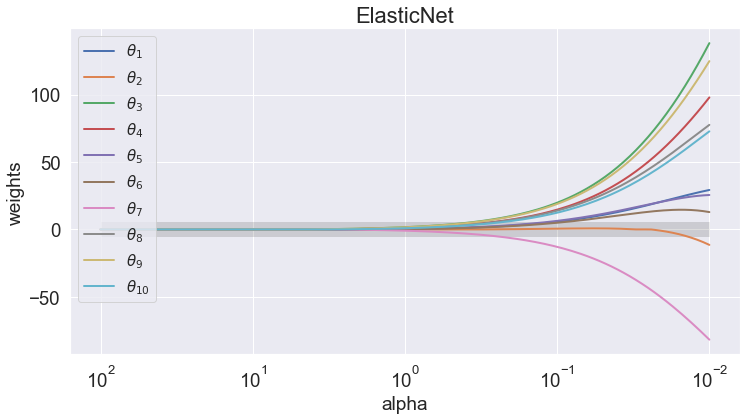

In [30]:
draw_track(Ridge(fit_intercept=False), X, y, -1.5, 5, 200, 
           title='Ridge')
draw_track(Lasso(fit_intercept=False), X, y, -2, 2.5, 200, 
           title='Lasso')
draw_track(ElasticNet(fit_intercept=False, l1_ratio=1/3), X, y, -2, 2, 200, 
           title='ElasticNet')

Из графиков выше можно сделать вывод, что при высоких значениях коэффициента регуляризации модели не учатся и все коээфициенты зануляются.  Также важно заметить, что Lasso при высоких значениях коэффициента регуляризации склонна занулять параметры, но в отличие от других моделей она **отбирает** определенные признаки начиная с некоторого значения коэффициента регуляризации. Другими словами, с ослаблением регуляризации Lasso присваивает ненулевые значения лишь каким-то конкретным признакам, которые считает наиболее важными. 

## Вероятностный и оптимизационный подходы

На занятии вы узнали, что регрессионную модель можно рассматривать как в вероятностном, так и в оптимизационном подходе. Для вероятностного подхода при этом должны выполняться вероятностные свойства. Давайте повторим теорию про оба подхода для Ridge-регрессии:

![Table](https://sun9-31.userapi.com/c206616/v206616568/64a15/b4E7eCybiog.jpg)

Таким образом, если данные обладают необходимыми свойствами, то мы можем построить доверительные интервалы для предсказаний модели. Вспомним, что линейную модель называют гауссовской, если $\varepsilon$ ~ $\mathcal{N}(0, \sigma^2 I_n)$, где $\varepsilon$ &mdash; остатки модели.

Рассмотрим данные о квартирах в Москве.

In [31]:
flats_data = pd.read_csv('flats_moscow.txt', delimiter='\t', index_col='n')

In [32]:
flats_data.head()

,price,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,code
n,,,,,,,,,,
1,81,58,40,6.0,12.5,7,1,1,1,3
2,75,44,28,6.0,13.5,7,1,0,1,6
3,128,70,42,6.0,14.5,3,1,1,1,3
4,95,61,37,6.0,13.5,7,1,0,1,1
5,330,104,60,11.0,10.5,7,0,1,1,3


Мы будем использовать признаки `price` &mdash; цена квартиры и `totsp` &mdash; площадь квартиры.

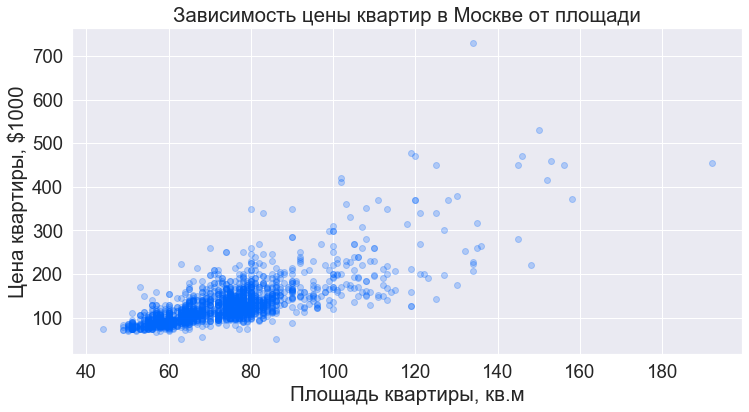

In [33]:
plt.figure(figsize=(12, 6))
plt.scatter(flats_data['totsp'], flats_data['price'], c='#0066FF', alpha=0.25)
plt.title('Зависимость цены квартир в Москве от площади')
plt.xlabel('Площадь квартиры, кв.м')
plt.ylabel('Цена квартиры, $1000')
plt.show()

На графике явно видна гетероскедостичность. 

In [34]:
X = flats_data[['totsp']]
y = flats_data['price']

Центрируем данные.

In [35]:
X  = (X - X.mean(axis=0)) / X.std(axis=0)
y = (y - y.mean()) / y.std()

Обучим модель и сделаем предсказание.

In [36]:
reg_coef = 0.1
model = Ridge(alpha=reg_coef)
model.fit(X, y)
y_pred = model.predict(X)

In [37]:
n = X.shape[0]  # количество объектов 
d = X.shape[1]  # количество признаков

Для оценки параметра 1/$\beta$ используем оценку $\frac{\lVert Y - X \theta\rVert^2_2}{n - d}$

In [38]:
b = (n - d) / np.sum((y_pred - y) ** 2) 
a = reg_coef * b
sigma = 1 / (b * X.T @ X + a)

Построим предиктивные интервалы для отклика. Для этого вспомним, что в линейной гауссовской модели $\varepsilon$ ~ $\mathcal{N}(0, \beta^{-1} I_n)$. 

Пусть $x_0$ &mdash; новый объект, а $y_0 = x_0^T\theta + \varepsilon_0$ &mdash; наблюдаемый отклик на $x_0$. 

Тогда 

$$
Y_0 | Y \sim \mathcal{N} \left( \beta x_0^T  \Sigma  X^T  Y, x_0^T  \Sigma  x_0 + \beta^{-1} \right).
$$
Квантили данного распределения задают границы предиктивного интервала.

In [39]:
left = []
right = []
estimations = []

for x0 in X.values:
    x0 = x0.reshape(-1, 1).T
    y0 = model.predict(x0)
    estimations.append(y0)
    
    distr = norm(
        b * x0.T @ sigma @ X.T @ y, np.sqrt(x0.T @ sigma * x0 + 1 / b)
    )
    left.append(distr.ppf(0.975).ravel())
    right.append(distr.ppf(0.025).ravel())

Посмотроим график предсказаний и предиктивный интервал.

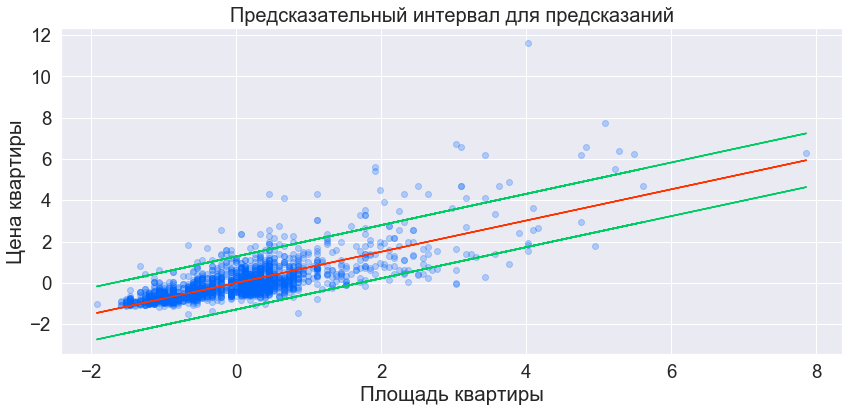

In [40]:
plt.figure(figsize=(14,6))
plt.scatter(X['totsp'], y, c='#0066FF', alpha=0.25)
plt.plot(X['totsp'], estimations, c='#FF3300')
plt.plot(X['totsp'], left, color='#00CC66')
plt.plot(X['totsp'], right, color='#00CC66')
plt.title('Предсказательный интервал для предсказаний', fontsize=20)
plt.xlabel('Площадь квартиры')
plt.ylabel('Цена квартиры')
plt.show()

Видим, что теоретические свойства не выполнены &mdash; слишком много объектов не попадают в предсказательный интервал. Это произошло из-за того, что ошибки модели гетероскедастичны.

Для решения данной проблемы попробуем посмотреть зависимость логарифма таргета от логарифма признака.

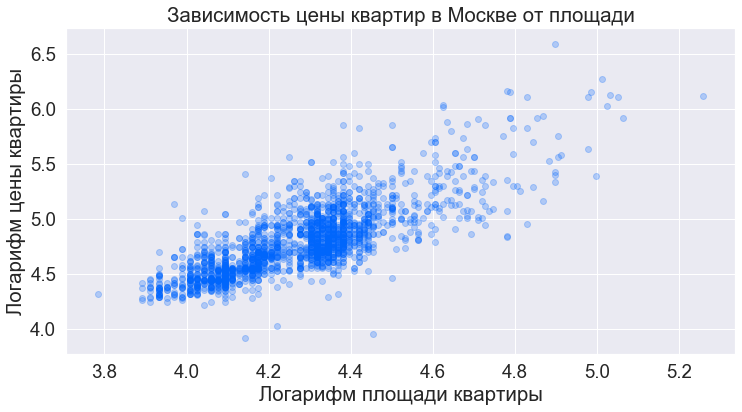

In [41]:
plt.figure(figsize=(12, 6))
plt.scatter(np.log(flats_data['totsp']), np.log(flats_data['price']), 
            c='#0066FF', alpha=0.25)
plt.title('Зависимость цены квартир в Москве от площади')
plt.xlabel('Логарифм площади квартиры')
plt.ylabel('Логарифм цены квартиры')
plt.show()

Задаем новую выборку и новый таргет &mdash; берем их логарифмы.

In [42]:
X = np.log(flats_data[['totsp']])
y = np.log(flats_data['price'])

Центрируем данные.

In [43]:
X = (X - X.mean(axis=0)) / X.std(axis=0)
y = (y - y.mean()) / y.std()

Обучаем модель.

In [44]:
reg_coef = 0.1
model = Ridge(alpha=reg_coef)
model.fit(X, y)
y_pred = model.predict(X)

Оцениваем параметры гауссовской модели.

In [45]:
b = (n - d) / np.sum((y_pred - y) ** 2) 
a = reg_coef * b
sigma = 1 / (b * X.T @ X + a)

Считаем предиктивный интервал.

In [46]:
left = []
right = []
estimations = []

for x0 in X.values:
    x0 = x0.reshape(-1, 1)
    y0 = model.predict(x0)
    estimations.append(y0)
    
    distr = norm(
        b * x0.T @ sigma @ X.T @ y, np.sqrt(x0.T @ sigma * x0 + 1 / b)
    )
    left.append(distr.ppf(0.975).ravel())
    right.append(distr.ppf(0.025).ravel())

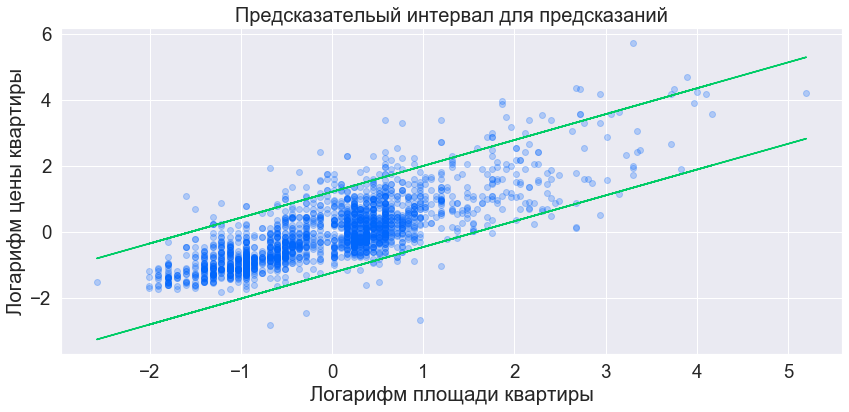

In [47]:
plt.figure(figsize=(14,6))
plt.scatter(X['totsp'], y, c='#0066FF', alpha=0.25)
plt.plot(X['totsp'], left, color='#00CC66')
plt.plot(X['totsp'], right, color='#00CC66')
plt.title('Предсказательый интервал для предсказаний', fontsize=20)
plt.xlabel('Логарифм площади квартиры')
plt.ylabel('Логарифм цены квартиры')
plt.show()

Видим, что ситуация улучшилась. Таком образом, если данные гетероскедастичны, то можно попробовать рассмотреть логарифмы признаков или таргета, это может улучшить предсказания.

Теперь рассмотрим датасет о потреблении мороженого.

In [48]:
ice_data = pd.read_csv('ice_cream.txt', delimiter='\t', index_col='date')

In [49]:
ice_data.head()

,IC,price,income,temp,Lag-temp,Year
date,,,,,,
1,0.386,0.270,78,41,56,0
2,0.374,0.282,79,56,63,0
3,0.393,0.277,81,63,68,0
4,0.425,0.280,80,68,69,0
5,0.406,0.272,76,69,65,0


Мы будем использовать признаки `IC` &mdash; потребление мороженого на человека, `temp` &mdash; температура воздуха в этот день.

Посмотрим, как зависит целевая переменная `IC` от `temp`.

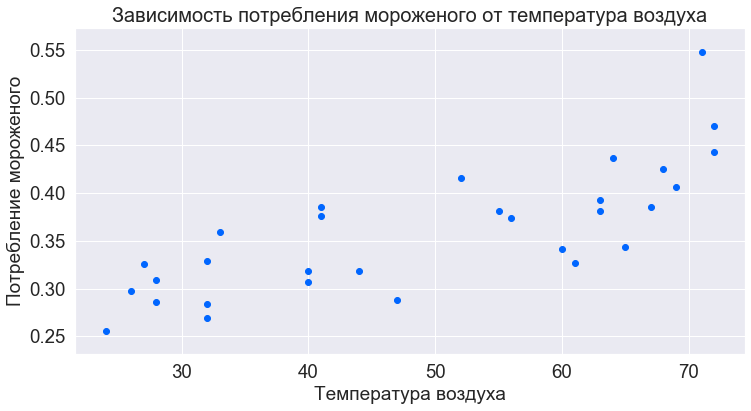

In [50]:
plt.figure(figsize=(12, 6))
plt.scatter(ice_data['temp'], ice_data['IC'], c='#0066FF')
plt.title('Зависимость потребления мороженого от температура воздуха', 
          fontsize=20)
plt.xlabel('Температура воздуха', fontsize=19)
plt.ylabel('Потребление мороженого', fontsize=19)
plt.show()

Из графика видна гомоскедастичность.

In [51]:
X = ice_data[['temp']]
y = ice_data['IC']

Центрируем данные.

In [52]:
X  = (X - X.mean(axis=0)) / X.std(axis=0)
y = (y - y.mean()) / y.std()

Обучаем модель и делаем предсказания.

In [53]:
reg_coef = 0.01
model = Ridge(alpha=reg_coef)
model.fit(X, y)
y_pred = model.predict(X)

In [54]:
n = X.shape[0]  # количество объектов 
d = X.shape[1]  # количество признаков

Оцениваем параметры гауссовской модели.

In [55]:
b = (n - d) / np.sum((y_pred - y) ** 2)
a = reg_coef * b
sigma = 1 / (b * X.T @ X + a)

Считаем предиктивный интервал.

In [56]:
left = []
right = []
estimations = []

for x0 in X.values:
    x0 = x0.reshape(-1, 1)
    y0 = model.predict(x0)
    estimations.append(y0)
    
    distr = norm(
        b * x0.T @ sigma @ X.T @ y, np.sqrt(x0.T @ sigma * x0 + 1 / b)
    )
    left.append(distr.ppf(0.975).ravel())
    right.append(distr.ppf(0.025).ravel())

Строим график зависимости таргета от признака и предиктивный интервал. 

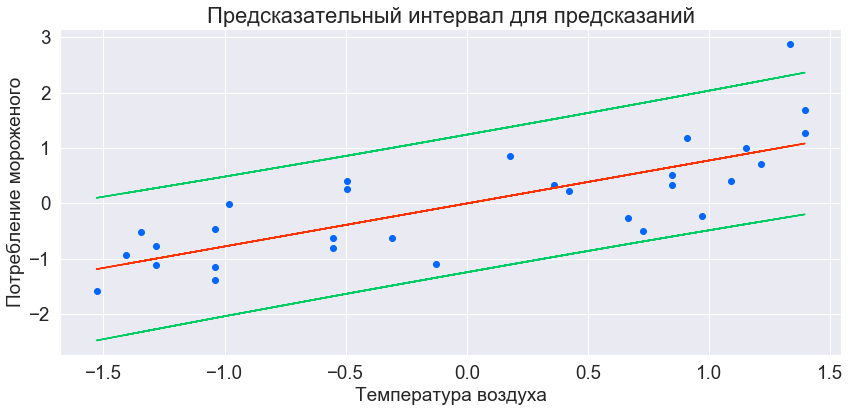

In [57]:
plt.figure(figsize=(14,6))
plt.scatter(X['temp'], y, c='#0066FF')
plt.plot(X['temp'], estimations, c='#FF3300')
plt.plot(X['temp'], left, color='#00CC66')
plt.plot(X['temp'], right, color='#00CC66')
plt.title('Предсказательный интервал для предсказаний', fontsize=22)
plt.xlabel('Температура воздуха', fontsize=19)
plt.ylabel('Потребление мороженого', fontsize=19)
plt.show()

Видим, что почти все предсказания попали в предсказательный интервал.

## Выводы

Таким образом, мы рассмотрели теоретические свойства для гауссовской модели и проверили их на практике в виде реализации предиктивных интервалов. Полезные следствия из гауссовской модели не работают на практике, если данные не удовлетворяют необходимым требованиям вероятностного подхода. В нашем случае, на гетероскедастичных данных не удалось построить предиктивный интервал с заявленными теоретическими свойствами. Как вариант, улучшить ситуацию с гетероскедастичностью можно при помощи экспериментов с логарифмами признаков.